# Rotated HEALPix grid representation back to the non_rotated HEALPix grid

To avoid having multiple HEALPix phase in the convolution step, some of the fish states matrixs are computed by applying Rotation in longittude direction rathaer than default non rotated HEALPix grid. 
Destination Earth Climate Twin are using non_rotated, default HEALPix.  
This notebook shows how to rotate back our computed state matrix to default non_rotated HEALPix grid.  


In [1]:
import xarray as xr
import xdggs 
import healpy as hp
import numpy as np

In [2]:
# Set up a local cluster for distributed computing.
from distributed import LocalCluster

cluster = LocalCluster()
client = cluster.get_client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 55.88 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36809,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 55.88 GiB
Comm: tcp://127.0.0.1:40059,Total threads: 2
Dashboard: http://127.0.0.1:40529/status,Memory: 13.97 GiB
Nanny: tcp://127.0.0.1:46743,


### We load the computed state matrix
The cell_ids here corresponds to rotated HEALPix grid's cell_id index.

In [3]:
import s3fs

# n.extension()
s3 = s3fs.S3FileSystem(
    anon=False,
    client_kwargs={
        "endpoint_url": "https://s3.gra.perf.cloud.ovh.net",
    },
)
states_file_path="gfts-ifremer/bargip/run/aderrien7/tracks_4/AD_A11146/states.zarr"
ds=xr.open_dataset("s3://"+states_file_path,engine='zarr')
ds

<xarray.Dataset> Size: 4GB
Dimensions:     (y: 1213, x: 1497, time: 243)
Coordinates:
    cell_ids    (y, x) int64 15MB ...
    latitude    (y, x) float64 15MB ...
    longitude   (y, x) float64 15MB ...
    resolution  float64 8B ...
  * time        (time) datetime64[ns] 2kB 2015-06-19 2015-06-20 ... 2016-02-16
Dimensions without coordinates: y, x
Data variables:
    states      (time, y, x) float64 4GB ...

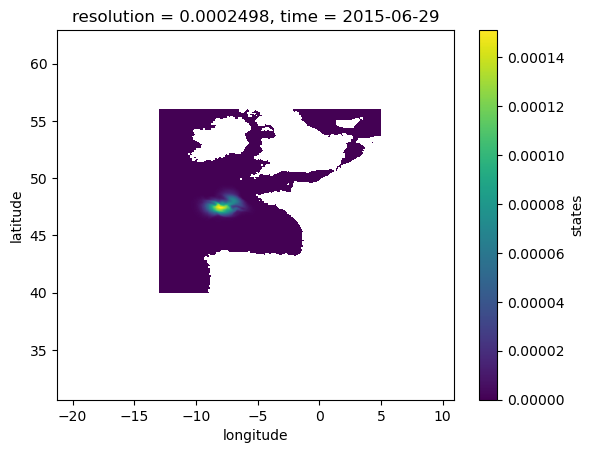

In [4]:
#set the same time step for plotting
time=10


ds.isel(time=time).states.plot(x='longitude',y='latitude')
#, rasterize=True,datashade=True, geo=True,tiles=True, )

### Annotate the Xarray representation with rotated and non rotated longitutde.

In [5]:
# set the parameters

nside=4096
nest=True

ds=xr.open_dataset("s3://"+states_file_path,engine='zarr', chunks={})


data = (
    ds.isel(time=slice(0,15))  ## i keep only this for testing fast.
    .rename_vars({"latitude": "lat_good", "longitude": "lon_good"})
    .stack(cell=["x", "y"], create_index=False)
).chunk({"time":1})
data.cell_ids.attrs = {
    "grid_name": "healpix",
    "nside": nside,
    "nest": nest,
}
data=data.pipe(xdggs.decode)

#compute the rotated latitude and longituted based on the rotated cell_ids. 
data=data.assign_coords(
    data.dggs.cell_centers().coords
).rename_vars({"longitude": "lon_rotated"}).drop_vars("latitude")

#drop cell's which only has the np.nan for all the time series here. 
data = data.dropna(dim="cell", subset=["states"], how= "all")
data

<xarray.Dataset> Size: 67MB
Dimensions:      (cell: 442725, time: 15)
Coordinates:
  * cell_ids     (cell) int64 4MB dask.array<chunksize=(442725,), meta=np.ndarray>
    lat_good     (cell) float64 4MB dask.array<chunksize=(442725,), meta=np.ndarray>
    lon_good     (cell) float64 4MB dask.array<chunksize=(442725,), meta=np.ndarray>
    resolution   float64 8B ...
  * time         (time) datetime64[ns] 120B 2015-06-19 2015-06-20 ... 2015-07-03
    lon_rotated  (cell) float64 4MB 328.4 328.4 328.4 ... 317.0 317.1 317.0
Dimensions without coordinates: cell
Data variables:
    states       (time, cell) float64 53MB dask.array<chunksize=(1, 442725), meta=np.ndarray>
Indexes:
    cell_ids  HealpixIndex(nside=12, indexing_scheme=nested)

In [6]:
rotated_angle__lon=(data.lon_rotated[0] - data.lon_good[0]).data.compute()
rotated_angle__lon

330.0

In [7]:
data.states.isel(time=time).compute().dggs.explore(cmap="viridis", alpha=0.8)

/srv/conda/envs/notebook/lib/python3.12/site-packages/distributed/client.py:3362: UserWarning: Sending large graph of size 13.52 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


Map(layers=[SolidPolygonLayer(filled=True, get_fill_color=<pyarrow.lib.FixedSizeListArray object at 0x7f164482…

In [8]:
data["states_rotated"]=data.states
data["cell_ids_rotated"]=data.cell_ids
theta=(90 - data.lat_good.compute())/180 * np.pi
ph = (data.lon_good.compute()+360)/180 *np.pi
ph = np.fmod(ph,np.pi*2)
cell_id_new= hp.ang2pix(nside,theta,ph,nest=True) 
data["cell_ids"]=cell_id_new
ph_rotated=ph+rotated_angle__lon/180*np.pi
ids_weight, weight= hp.get_interp_weights(nside,theta,ph_rotated,nest=True)
data

/srv/conda/envs/notebook/lib/python3.12/site-packages/distributed/client.py:3362: UserWarning: Sending large graph of size 10.14 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


<xarray.Dataset> Size: 124MB
Dimensions:           (cell: 442725, time: 15)
Coordinates:
    cell_ids          (cell) int64 4MB 55960939 55961024 ... 58464747 58465088
    lat_good          (cell) float64 4MB dask.array<chunksize=(442725,), meta=np.ndarray>
    lon_good          (cell) float64 4MB dask.array<chunksize=(442725,), meta=np.ndarray>
    resolution        float64 8B ...
  * time              (time) datetime64[ns] 120B 2015-06-19 ... 2015-07-03
    lon_rotated       (cell) float64 4MB 328.4 328.4 328.4 ... 317.0 317.1 317.0
Dimensions without coordinates: cell
Data variables:
    states            (time, cell) float64 53MB dask.array<chunksize=(1, 442725), meta=np.ndarray>
    states_rotated    (time, cell) float64 53MB dask.array<chunksize=(1, 442725), meta=np.ndarray>
    cell_ids_rotated  (cell) int64 4MB dask.array<chunksize=(442725,), meta=np.ndarray>

In [9]:
def regrid_to_rotate(data, cell_ids_rotated, ids_weight, weight):
    in_map = {}
    for l in range(4):
        for k in ids_weight[l]:
            in_map[k]=0.0
    
    for k in range(len(cell_ids_rotated)) :
        in_map[cell_ids_rotated[k]]=data[k]
    result=weight[0] * np.array([ in_map[k] for k in ids_weight[0]])
    result +=weight[1] * np.array([ in_map[k] for k in ids_weight[1]])
    result +=weight[2] * np.array([ in_map[k] for k in ids_weight[2]])
    result +=weight[3] * np.array([ in_map[k] for k in ids_weight[3]])
    return data

In [10]:
data["states"][:, :]=xr.apply_ufunc( 
    regrid_to_rotate
    ,data.states_rotated
    ,data.cell_ids_rotated
    ,ids_weight
    ,weight
    ,input_core_dims=[[ "cell"], ["cell"],["z","cell"],["z","cell"] ]
    ,output_core_dims=[["cell"],] 
    ,exclude_dims=set(("z",))  
    ,vectorize=True  
    ,dask="parallelized"
    ,output_dtypes=[data.states.dtype]  
    )

In [11]:
data.cell_ids.attrs = {
    "grid_name": "healpix",
    "nside": 4096,
    "nest": True,
}
data=data.pipe(xdggs.decode)
data

<xarray.Dataset> Size: 124MB
Dimensions:           (cell: 442725, time: 15)
Coordinates:
  * cell_ids          (cell) int64 4MB 55960939 55961024 ... 58464747 58465088
    lat_good          (cell) float64 4MB dask.array<chunksize=(442725,), meta=np.ndarray>
    lon_good          (cell) float64 4MB dask.array<chunksize=(442725,), meta=np.ndarray>
    resolution        float64 8B ...
  * time              (time) datetime64[ns] 120B 2015-06-19 ... 2015-07-03
    lon_rotated       (cell) float64 4MB 328.4 328.4 328.4 ... 317.0 317.1 317.0
Dimensions without coordinates: cell
Data variables:
    states            (time, cell) float64 53MB dask.array<chunksize=(1, 442725), meta=np.ndarray>
    states_rotated    (time, cell) float64 53MB dask.array<chunksize=(1, 442725), meta=np.ndarray>
    cell_ids_rotated  (cell) int64 4MB dask.array<chunksize=(442725,), meta=np.ndarray>
Indexes:
    cell_ids  HealpixIndex(nside=12, indexing_scheme=nested)

In [12]:
data.states.isel(time=time).compute().dggs.explore(cmap="viridis", alpha=0.8)

/srv/conda/envs/notebook/lib/python3.12/site-packages/distributed/client.py:3362: UserWarning: Sending large graph of size 40.54 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


Map(layers=[SolidPolygonLayer(filled=True, get_fill_color=<pyarrow.lib.FixedSizeListArray object at 0x7f164481…

In [13]:
data.to_zarr('toto.zarr',mode='w')

/srv/conda/envs/notebook/lib/python3.12/site-packages/distributed/client.py:3362: UserWarning: Sending large graph of size 40.55 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
